In [ ]:
sc.stop()

In [33]:
# import findspark
import findspark
# initialize findspark with spark directory
findspark.init("C:\BigData\BigData\spark-3.1.2-bin-hadoop3.2")
# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\vikto\AppData\Local\Temp\ipykernel_52340\2064577265.py:8 

In [22]:
# import pyspark sql functions as F
import pyspark.sql.functions as F
# imort os
import os 
import re
from datetime import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

In [23]:
spark

NameError: name 'spark' is not defined

In [4]:
#set this path to your path, for some reason I have an error 
#reading in all the files
path_json = ".././../data/Topic_vegan/*.json"

In [5]:
df_json = spark.read.option("multiline","true").json(path_json)

In [10]:
# check the schema of our json dataframe
df_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

# The volume of the tweets

First we will look at the total number of tweets

In [6]:
# select interesting features 
twitter_sub = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("user.followers_count"))

In [67]:
# check
twitter_sub.limit(5).toPandas()

,name,screen_name,created_at,full_text,followers_count
0,のり/Nori,nori_k_629,Mon Apr 04 10:09:55 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,139
1,alice,myn4meizalize,Mon Apr 04 10:09:54 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,655
2,Karen Reed 🌸,kandk670,Mon Apr 04 10:09:54 +0000 2022,@trudiebakescake Organic coconut oil in a jar ...,711
3,ハル):),patlnwza55,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,236
4,alice,myn4meizalize,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,655


In [7]:
# remove duplicates and retweets
twitter_processed = twitter_sub.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates() \
                               .cache()

In [ ]:
# check
twitter_processedPd = twitter_processed.toPandas()
twitter_processedPd.head()

In [8]:
# calculate the number of tweets in our dataset 
twitter_processed.count()

1443391

We have a total of 1443391 distinct tweets

Now we will look at the number of distinct users that tweeted about the subject 

In [71]:
# select the number of distinct users from our dataframe 
numberOfUsers = twitter_processed.select(F.countDistinct("screen_name").alias("NumberOfUsers"))

In [72]:
numberOfUsers.show()

+-------------+
|NumberOfUsers|
+-------------+
|       577959|
+-------------+



There are a total of 577959 users that posted a tweet about the subject 

There were a total number of 1443391 tweets so this means that each user posts 2,5 tweets on average

Now we will look at the number of characters of tweets

# The timing of tweets 

First we will check the latest and earliest date a tweet was placed 

In [1]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.utc).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate)

# apply udf
twitter_processed = twitter_processed.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

NameError: name 'F' is not defined

# The number of folowers of tweeters

Because a user can post more than one tweets about the topic, some users will appear more than once in our dataset. The user can have a different number of followers, becuase the number of followers may have been increased or decreased between the time of the tweets. We decide to take the max of the number of followers for each users.  


In [90]:
# we select the max number of followers for each users 
numberOfFollowers = twitter_processed.select("name", "followers_count") \
                                        .groupBy("name") \
                                        .max("followers_count") \
                                        .withColumnRenamed("max(followers_count)", "MaxFollowersCount") \
                                        .withColumn("MaxFollowersCount", F.round("MaxFollowersCount", 2)) 

In [94]:
# we sort in a decending way
numberOfFollowers = numberOfFollowers.sort("MaxFollowersCount", ascending=False)

In [ ]:
# converting to pandas
numberofFollowersPd = numberOfFollowers.toPandas()

In [103]:
# look at the 20 accounts with the largest number of followers
numberofFollowersPd.head(20)

,name,MaxFollowersCount
0,Lady Gaga,84876971
1,CNN,58738132
2,The New York Times,53833653
3,BBC News (World),37368190
4,The Economist,26981263
5,Reuters,25387151
6,A.R.Rahman,24192397
7,Nicki Minaj,23311089
8,Fox News,22083552
9,The Wall Street Journal,19901847


We can see that the accounts with the largest number of followers are famous people or news sites. Which shows us that it's an item that's actual at the moment

In [108]:
# now we will look how mucht users have 0 followers
zeroFollowers = numberofFollowersPd[numberofFollowersPd['MaxFollowersCount'] == 0]
zeroFollowers.head()

,name,MaxFollowersCount
532066,CookingCompass,0
532067,Geetha Masala,0
532068,Green Field,0
532069,The Warehouse 365,0
532070,Hardy.Legros,0


In [109]:
len(zeroFollowers)

10963

In [111]:
len(zeroFollowers)/len(numberofFollowersPd)

0.02018860871150528

Only 2% of the users have zero followers

In [135]:
# now we will look how mucht users have 0 followers
lessThan1000Followers = numberofFollowersPd[numberofFollowersPd['MaxFollowersCount'] < 1000]
len(lessThan1000Followers)

390215

In [136]:
len(lessThan1000Followers)/len(numberofFollowersPd)

0.7185896149192769

Most users (71,86 %) have less than 1000 followers

In [124]:
# look how much followers our users have on average 
meanFollowers = numberofFollowersPd['MaxFollowersCount'].mean()
meanFollowers

7351.733467273387

C:\Users\vikto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


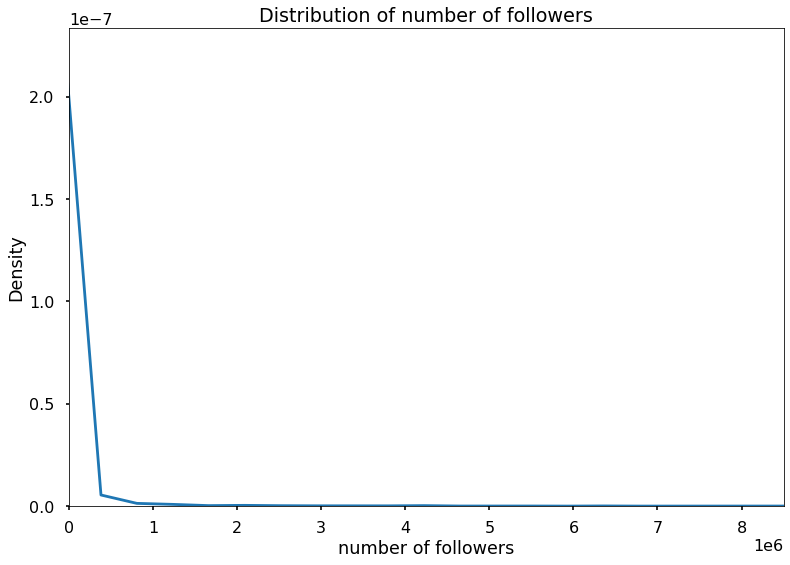

In [134]:
style.use('seaborn-poster')
sns.distplot(numberofFollowersPd['MaxFollowersCount'], hist = False)
plt.xlim(xmin=0, xmax = 8500000)
plt.title("Distribution of number of followers")
plt.xlabel("number of followers")
plt.show()